In [23]:
import sys
!{sys.executable} -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

print(torch.__version__)

1.11.0+cu113


In [44]:
data_dir = 'Cat_Dog'

# train_dir = 'Cat_Dog/train'
# test_dir = 'Cat_Dog/test'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

torch.Size([3, 224, 224])

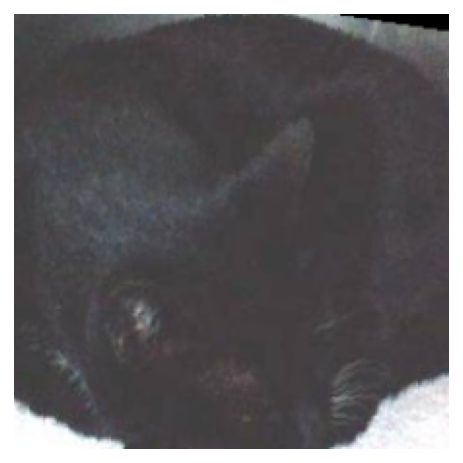

In [34]:
images, labels = next(iter(trainloader))
helper.imshow(images[0],normalize=True)

images[0].shape

In [35]:
# from torchvision.models import DenseNet121_Weights
from torchvision import models

# model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [36]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(1024,500)),
    ('relu',nn.ReLU()),
    ('fc2',nn.Linear(500,2)),
    ('output',nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [37]:
import time

for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break

    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 1.641 seconds
Device = cuda; Time per batch: 0.012 seconds


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [31]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr = 0.001)
print_every = 40
epochs = 3
steps = 0

model.to(device)

for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(trainloader):
        steps +=1

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:

            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))

            running_loss = 0


Epoch: 1/3...  Loss: 0.6505
Epoch: 1/3...  Loss: 0.6400
Epoch: 1/3...  Loss: 0.6434
Epoch: 1/3...  Loss: 0.6413
Epoch: 1/3...  Loss: 0.6310
Epoch: 1/3...  Loss: 0.6415
Epoch: 1/3...  Loss: 0.6340
Epoch: 1/3...  Loss: 0.6446
Epoch: 1/3...  Loss: 0.6356
Epoch: 1/3...  Loss: 0.6285
Epoch: 1/3...  Loss: 0.6366
Epoch: 1/3...  Loss: 0.6353
Epoch: 1/3...  Loss: 0.6386
Epoch: 1/3...  Loss: 0.6407
Epoch: 2/3...  Loss: 0.2259
Epoch: 2/3...  Loss: 0.6336
Epoch: 2/3...  Loss: 0.6383
Epoch: 2/3...  Loss: 0.6359
Epoch: 2/3...  Loss: 0.6356
Epoch: 2/3...  Loss: 0.6390


KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
